# Capstone Project: Udacity Machine Learning Engineer
## Hans Fricke, 05-18-2018
## Unsupervised learning, text data aggregation, topic modelling

In [1]:
# import packages
import pandas as pd
import os
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [2]:
# display formatting
%matplotlib inline 
pd.options.display.float_format = '{:20,.2f}'.format

# change working directory
os.chdir("/Users/hansfricke/Dropbox/ND ML Engineer/Capstone")

In [3]:
proposals = pd.read_pickle('Data/pre_cleaned_proposals.pkl')

### Functions to prep text data and model topics

##### Tfidf vectorization

In [4]:
def tfidf_vectorize(text, no_features):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features)
    tfidf = tfidf_vectorizer.fit_transform(text)
    feature_names = tfidf_vectorizer.get_feature_names()
    return tfidf, feature_names

##### Principal component analysis fit only

In [5]:
def pca(word_array, no_topics):
    pca_fit = PCA(n_components=no_topics, 
              random_state=1).fit(word_array)
    return pca_fit

### Functions to determine number of components

##### Function for number of components

In [6]:
def get_n_components(model, min_decrease_var):
    var = model.explained_variance_ratio_
    decrease = (var[:-1]-var[1:])/var[:-1]
    max_index = np.argmax(decrease < min_decrease_var)
    return max_index + 1    

##### Function to decreases in shared variance for each additional component

In [7]:
def plot_decrease_var(model, n_components, path, name):
    var = model.explained_variance_ratio_
    cumvar = np.cumsum(var)  
    x = range(60)
    plt.plot(x,cumvar)
    plt.axvline(n_components, color='red')
    plt.xlabel('Number of components')
    plt.ylabel('Cummulative variance')
    plt.title(name)
    save_as = path + "/" + name + ".png"
    plt.savefig(save_as)
    plt.show()

### Function to add components to data

In [8]:
def join_components_to_data(model, word_array, n_components, dataframe, prefix):
    new_column_names = [prefix + 'Components' + str(n) for n in range(0, n_components)]
    components = pd.DataFrame(model.transform(word_array))
    dataframe[new_column_names] = components.iloc[:,:n_components]
    return dataframe

### Apply all that to all text columns

In [9]:
text_cols = ['c_essay1', 'c_essay2', 'c_resource_summary', 'c_total_description']

##### Tfidf factorization

In [10]:
tfidf = {}
for text_col in text_cols:
    tfidf_matrix, features = tfidf_vectorize(proposals[text_col], 1000)
    tfidf[text_col] = {'tfidf': tfidf_matrix.todense(), 
                        'features': features}

##### Fit pca with a lot of components

In [11]:
pcas = {}
for text_col in text_cols:
    pcas[text_col] = pca(tfidf[text_col]['tfidf'], 60)

##### Determinde number of topics

In [12]:
number_components = {}
for text_col in text_cols:
    number_components[text_col] = get_n_components(pcas[text_col], 0.01,)

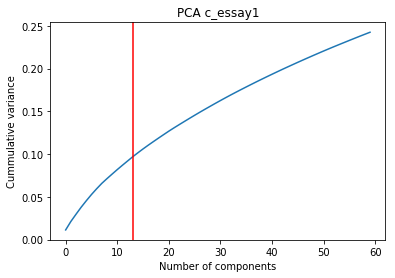

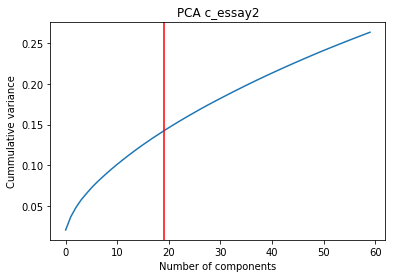

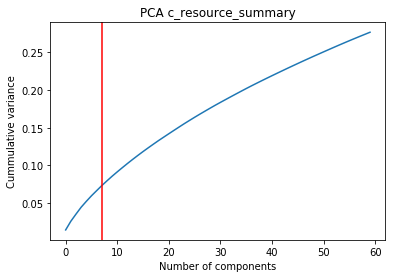

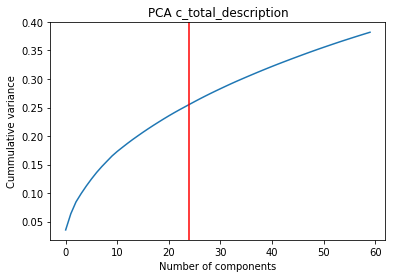

In [13]:
for text_col in text_cols:
    name = 'PCA ' + text_col
    plot_decrease_var(pcas[text_col], number_components[text_col], './Graphs', name)

##### Extract components according to determined number, and create new data frame will all components

In [14]:
pca_components = pd.DataFrame(proposals['id'])
for text_col in text_cols:
    pca_components = join_components_to_data(pcas[text_col], 
                                             tfidf[text_col]['tfidf'], 
                                             number_components[text_col],
                                             pca_components, text_col)

In [15]:
pca_components.to_pickle('Data/pca_components.pkl')